In [3]:
import pandas as pd
from datetime import datetime
import MetaTrader5 as mt5
import time

# Global constants
SYMBOL = 'EURUSD'
VOLUME = 0.70
TIMEFRAME = mt5.TIMEFRAME_M1
SMA_PERIOD = 10
DEVIATION = 20
STOP_LOSS_PIPS = 10  # Set your desired stop loss in pips
TAKE_PROFIT_PIPS = 20  # Set your desired take profit in pips

# Initialize MetaTrader 5
mt5.initialize()

def market_order(symbol, volume, order_type, stop_loss=None, take_profit=None):
    # Get symbol price
    tick = mt5.symbol_info_tick(symbol)
    order_dict = {'buy': 0, 'sell': 1}
    price_dict = {'buy': tick.ask, 'sell': tick.bid}
    
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": volume,
        "type": order_dict[order_type],
        "price": price_dict[order_type],
        "deviation": DEVIATION,
        "magic": 100,
        "Comment": "python market order",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    
    # Set stop loss and take profit if provided
    if stop_loss is not None:
        request["sl"] = price_dict[order_type] - (stop_loss * mt5.symbol_info(symbol).point)
    if take_profit is not None:
        request["tp"] = price_dict[order_type] + (take_profit * mt5.symbol_info(symbol).point)
    
    order_result = mt5.order_send(request)
    print(order_result)

    return order_result

def signal(symbol, time_frame, sma_period):
    bars = mt5.copy_rates_from_pos(symbol, time_frame, 1, sma_period)
    bars_df = pd.DataFrame(bars)

    last_close = bars_df.iloc[-1].close
    sma = bars_df.close.mean()

    if last_close > sma:
        direction = 'buy'
    elif last_close < sma:
        direction = 'sell'
    else:
        direction = 'flat'

    return last_close, sma, direction

def close_order(ticket):
    positions = mt5.positions_get()

    for pos in positions:
        tick = mt5.symbol_info_tick(pos.symbol)
        type_dict = {0: 1, 1: 0}
        price_dict = {0: tick.ask, 1: tick.bid}

        if pos.ticket == ticket:
            request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": pos.symbol,
                "volume": pos.volume,
                "type": type_dict[pos.type],
                "price": price_dict[pos.type],
                "deviation": DEVIATION,
                "magic": 100,
                "Comment": "python close order",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_IOC,
            }
            order_result = mt5.order_send(request)
            print(order_result)
            return order_result
def close_positions(opposite_direction):
    positions = mt5.positions_get()

    for pos in positions:
        if pos.type == 0:  # Check if it's a sell position
            if opposite_direction == 'buy':
                close_order(pos.ticket)
        elif pos.type == 1:  # Check if it's a buy position
            if opposite_direction == 'sell':
                close_order(pos.ticket)
        
def get_exposure(symbol):
    positions = mt5.positions_get(symbol = symbol)
    if positions:
        pos_df = pd.DataFrame(positions, columns = positions[0]._asdict().keys())
        exposure = pos_df['volume'].sum()
        return exposure

if __name__ == '__main__':
    while True:
        exposure = get_exposure(SYMBOL)
        last_close, sma, direction = signal(SYMBOL, TIMEFRAME, SMA_PERIOD)

        # Close existing positions with the opposite direction
        close_positions(direction)

        # Place new market order with dynamic stop loss and take profit
        if direction == 'buy':
            market_order(SYMBOL, VOLUME, direction, STOP_LOSS_PIPS, TAKE_PROFIT_PIPS)
        elif direction == 'sell':
            market_order(SYMBOL, VOLUME, direction, STOP_LOSS_PIPS, TAKE_PROFIT_PIPS)

        print('time:', datetime.now())
        print('exposure:', exposure)
        print('last_close', last_close)
        print('sma: ', sma)
        print('signal:', direction)
        print('--------------\n')
        time.sleep(1)


OrderSendResult(retcode=10021, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='No prices', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=100, order=0, symbol='EURUSD', volume=0.7, price=1.06239, stoplimit=0.0, sl=0.0, tp=0.0, deviation=20, type=1, type_filling=1, type_time=0, expiration=0, comment='', position=0, position_by=0))
OrderSendResult(retcode=10021, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='No prices', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=100, order=0, symbol='EURUSD', volume=0.7, price=1.06239, stoplimit=0.0, sl=0.0, tp=0.0, deviation=20, type=1, type_filling=1, type_time=0, expiration=0, comment='', position=0, position_by=0))
OrderSendResult(retcode=10021, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='No prices', request_id=0, retcode_external=0, request=TradeRequest(action=1, magic=100, order=0, symbol='EURUSD', volume=0.7, price=1.06239, stoplimit=0

KeyboardInterrupt: 

In [6]:
from datetime import datetime
import MetaTrader5 as mt5
import pandas as pd
import numpy as np

mt5.initialize()

# you code here
symbol = 'EURUSD'  # Replace with the trading symbol you want to use
support_level = 1.2000  # Set your support level
resistance_level = 1.2100  # Set your resistance level
volume = 0.01  # Set the trading volume

def calculate_resistance_levels(symbol, timeframe, lookback_period):
    """
    Calculate resistance levels based on historical price data.

    Args:
    - symbol: Trading symbol (e.g., 'EURUSD').
    - timeframe: Timeframe for historical data (e.g., mt5.TIMEFRAME_D1 for daily data).
    - lookback_period: Number of periods to look back for identifying resistance levels.

    Returns:
    - List of resistance levels as price levels.
    """
    # Load historical price data
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, lookback_period)
    if not rates:
        return []

    # Create a DataFrame from the historical data
    df = pd.DataFrame(rates)
    
    # Identify potential resistance levels (high prices)
    support_levels = df['low'].nsmallest(lookback_period).unique()
    resistance_levels = df['high'].nlargest(lookback_period).unique()
    
    
     
    if resistance_levels:
        print(f"Resistance Levels for {symbol} (Last {lookback_period} days):")
        for level in resistance_levels:
            print(f"Resistance Level: {level:.4f}")
    else:
        print(f"No resistance levels found for {symbol}.")

    return resistance_levels,support_levels

# Trading strategy
def support_resistance_strategy():
    # Get the current price
    symbol = 'EURUSD'
    tick = mt5.symbol_info_tick(symbol)
    current_price = tick.bid
    timeframe = mt5.TIMEFRAME_M1    # Daily timeframe
    lookback_period = 30  # Look back 30 periods
    resistance_levels, support_levels = calculate_resistance_levels(symbol, timeframe, lookback_period)

    if current_price >= resistance_levels[-1]:
        # Price reached resistance level, sell
        return 'Sell'

    if current_price <= support_levels[-1]:
        # Price reached support level, buy
        return 'Buy'

    return 'Hold'

# Main trading loop
while True:
    # Apply trading strategy
    action = support_resistance_strategy()

    if action == 'Buy':
        # Place a buy order
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": volume,
            "type": mt5.ORDER_BUY,
            "price": mt5.symbol_info_tick(symbol).ask,
            "deviation": 20,
            "magic": 100,
            "Comment": "Support/Resistance Buy",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }
        order_result = mt5.order_send(request)
        print(f"Buy order result: {order_result}")

    elif action == 'Sell':
        # Place a sell order
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": volume,
            "type": mt5.ORDER_SELL,
            "price": mt5.symbol_info_tick(symbol).bid,
            "deviation": 20,
            "magic": 100,
            "Comment": "Support/Resistance Sell",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }
        order_result = mt5.order_send(request)
        print(f"Sell order result: {order_result}")

    # Sleep for a while (adjust as needed)
    time.sleep(60)  # Sleep for 60 seconds (adjust the interval as needed)
# 

mt5.shutdown()



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [10]:
from datetime import datetime
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import time

mt5.initialize()

# Set your parameters
symbol = 'EURUSD'  # Replace with the trading symbol you want to use
volume = 0.01  # Set the trading volume

def calculate_resistance_levels(symbol, timeframe, lookback_period):
    """
    Calculate resistance levels based on historical price data.

    Args:
    - symbol: Trading symbol (e.g., 'EURUSD').
    - timeframe: Timeframe for historical data (e.g., mt5.TIMEFRAME_D1 for daily data).
    - lookback_period: Number of periods to look back for identifying resistance levels.

    Returns:
    - List of resistance levels as price levels.
    """
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, lookback_period)
    if not rates:
        return [], []  # Return empty lists for both resistance and support levels

    # Create a DataFrame from the historical data
    df = pd.DataFrame(rates)
    
    # Identify potential resistance levels (high prices)
    support_levels = df['low'].nsmallest(lookback_period).unique()
    resistance_levels = df['high'].nlargest(lookback_period).unique()
    
    if resistance_levels.any():
        print(f"Resistance Levels for {symbol} (Last {lookback_period} days):")
        for level in resistance_levels:
            print(f"Resistance Level: {level:.4f}")
    else:
        print(f"No resistance levels found for {symbol}.")

    return resistance_levels, support_levels

# Trading strategy
def support_resistance_strategy():
    # Get the current price
    symbol = 'EURUSD'
    tick = mt5.symbol_info_tick(symbol)
    current_price = tick.bid
    timeframe = mt5.TIMEFRAME_M1  # Daily timeframe
    lookback_period = 30  # Look back 30 periods
    resistance_levels, support_levels = calculate_resistance_levels(symbol, timeframe, lookback_period)

    if resistance_levels and (np.array(resistance_levels) >= current_price).any():
        # Price reached or exceeded at least one resistance level, sell
        return 'Sell'

    if support_levels and (np.array(support_levels) <= current_price).any():
        # Price reached or went below at least one support level, buy
        return 'Buy'

    return 'Hold'

# Main trading loop
while True:
    # Apply trading strategy
    action = support_resistance_strategy()

    if action == 'Buy':
        # Place a buy order
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": volume,
            "type": mt5.ORDER_BUY,
            "price": mt5.symbol_info_tick(symbol).ask,
            "deviation": 20,
            "magic": 100,
            "Comment": "Support/Resistance Buy",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }
        order_result = mt5.order_send(request)
        print(f"Buy order result: {order_result}")

    # Sleep for a while (adjust as needed)
    time.sleep(60)  # Sleep for 60 seconds (adjust the interval as needed)

mt5.shutdown()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [1]:
import requests
import pandas as pd

# Define the API URL with the correct parameters
symbol = "EURUSD"
interval = "5min"
api_key = "8L59AYZXIL1TTVFZ"
outputsize = "compact"  # You can change this to "full" if you want more data

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={api_key}&datatype=csv&outputsize={outputsize}'

# Make the API request and read the data into a DataFrame
response = requests.get(url)

if response.status_code == 200:
    data = pd.read_csv(url)
    print(data.shape)
    print(data.head())
else:
    print("Error: Failed to retrieve data from Alpha Vantage API")


(100, 6)
             timestamp    open    high     low   close  volume
0  2023-10-13 01:50:00  1.0544  1.0546  1.0544  1.0545       0
1  2023-10-13 01:45:00  1.0546  1.0546  1.0544  1.0544       0
2  2023-10-13 01:40:00  1.0548  1.0550  1.0545  1.0546       0
3  2023-10-13 01:35:00  1.0549  1.0550  1.0547  1.0548       0
4  2023-10-13 01:30:00  1.0548  1.0549  1.0548  1.0548       0


In [2]:
print(data)

              timestamp    open    high     low   close  volume
0   2023-10-13 01:50:00  1.0544  1.0546  1.0544  1.0545       0
1   2023-10-13 01:45:00  1.0546  1.0546  1.0544  1.0544       0
2   2023-10-13 01:40:00  1.0548  1.0550  1.0545  1.0546       0
3   2023-10-13 01:35:00  1.0549  1.0550  1.0547  1.0548       0
4   2023-10-13 01:30:00  1.0548  1.0549  1.0548  1.0548       0
..                  ...     ...     ...     ...     ...     ...
95  2023-10-12 17:55:00  1.0529  1.0529  1.0527  1.0528       0
96  2023-10-12 17:50:00  1.0529  1.0530  1.0528  1.0528       0
97  2023-10-12 17:45:00  1.0529  1.0530  1.0528  1.0529       0
98  2023-10-12 17:40:00  1.0528  1.0530  1.0527  1.0529       0
99  2023-10-12 17:35:00  1.0528  1.0529  1.0527  1.0529       0

[100 rows x 6 columns]


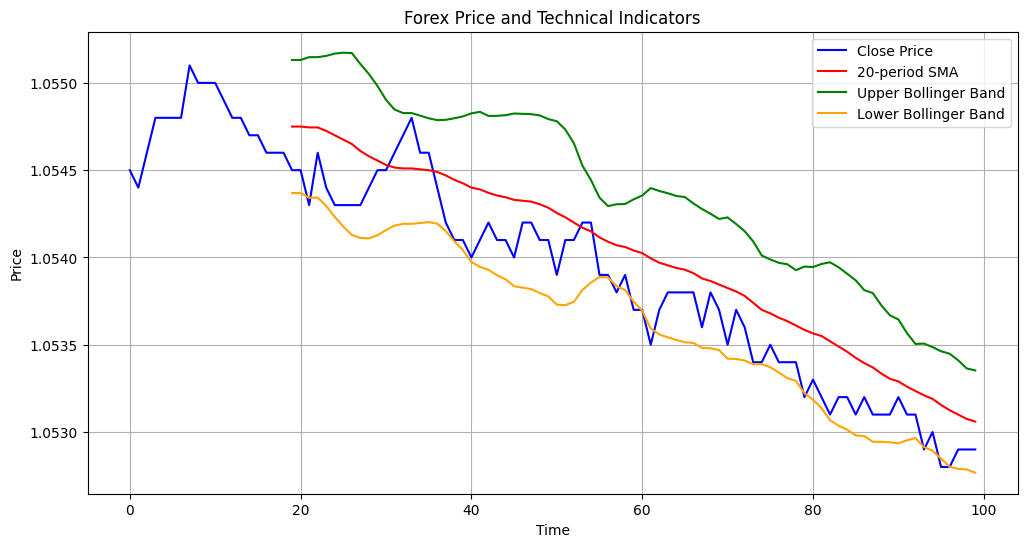

In [3]:
import matplotlib.pyplot as plt

data['SMA_20'] = data['close'].rolling(window=20).mean()

# Calculate Bollinger Bands
window = 20
std_multiplier = 2  # You can adjust this multiplier as needed
data['SMA'] = data['close'].rolling(window=window).mean()
data['StdDev'] = data['close'].rolling(window=window).std()
data['Upper_Band'] = data['SMA'] + (std_multiplier * data['StdDev'])
data['Lower_Band'] = data['SMA'] - (std_multiplier * data['StdDev'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Close Price', color='blue')
plt.plot(data.index, data['SMA_20'], label='20-period SMA', color='red')
plt.plot(data.index, data['Upper_Band'], label='Upper Bollinger Band', color='green')
plt.plot(data.index, data['Lower_Band'], label='Lower Bollinger Band', color='orange')

plt.title('Forex Price and Technical Indicators')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# short_window = 20
# long_window = 50

# data['Short_SMA'] = data['close'].rolling(window=short_window).mean()
# data['Long_SMA'] = data['close'].rolling(window=long_window).mean()

# # Define stop-loss and take-profit levels (example values)
# stop_loss_price = 1.1200  # Replace with your actual stop-loss level
# take_profit_price = 1.1400  # Replace with your actual take-profit level

# # Create a plot
# plt.figure(figsize=(12, 6))

# # Plot the closing price
# plt.plot(data.index, data['close'], label='Close Price', color='blue')

# # Plot buy positions (green) and sell positions (red)
# plt.plot(data[data['Signal'] == 1].index, data[data['Signal'] == 1]['close'], '^', markersize=10, color='g', label='Buy Signal')
# plt.plot(data[data['Signal'] == -1].index, data[data['Signal'] == -1]['close'], 'v', markersize=10, color='r', label='Sell Signal')

# # Plot stop-loss and take-profit levels as horizontal lines
# plt.axhline(stop_loss_price, color='red', linestyle='--', label='Stop Loss')
# plt.axhline(take_profit_price, color='green', linestyle='--', label='Take Profit')

# plt.title('Forex Price and Buy/Sell Signals with Stop Loss and Take Profit')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.show()

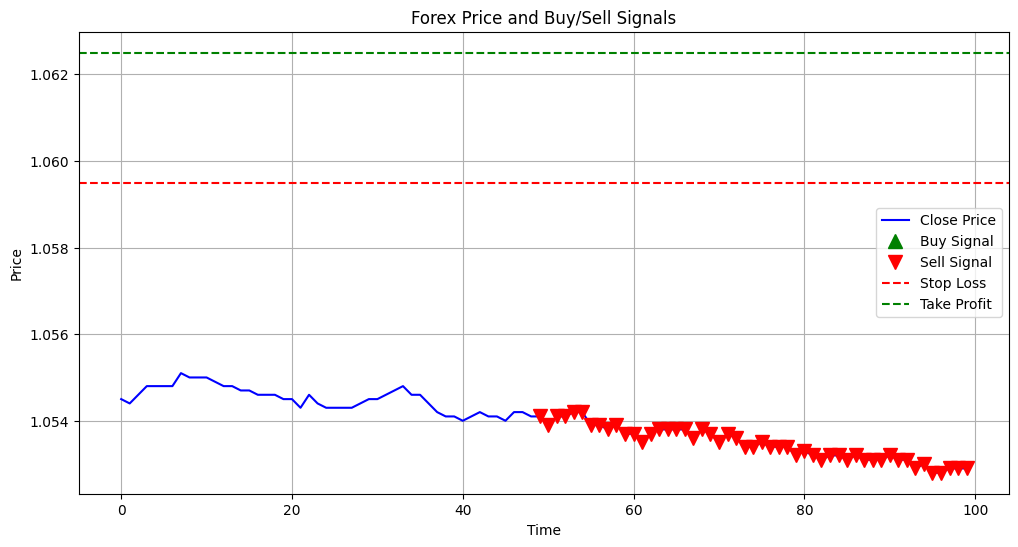

In [4]:
# Calculate short-term and long-term SMAs
short_window = 20
long_window = 50

data['Short_SMA'] = data['close'].rolling(window=short_window).mean()
data['Long_SMA'] = data['close'].rolling(window=long_window).mean()

# Initialize a 'Signal' column
data['Signal'] = 0  # 0 represents no action

# Generate buy (1) and sell (-1) signals
data.loc[data['Short_SMA'] > data['Long_SMA'], 'Signal'] = 1  # Buy signal
data.loc[data['Short_SMA'] < data['Long_SMA'], 'Signal'] = -1  # Sell signal

# Define stop-loss and take-profit levels (example values)
stop_loss_price = 1.0595  # Replace with your actual stop-loss level
take_profit_price = 1.0625

# Create a plot
plt.figure(figsize=(12, 6))

# Plot the closing price
plt.plot(data.index, data['close'], label='Close Price', color='blue')

# Plot buy positions (green) and sell positions (red)
plt.plot(data[data['Signal'] == 1].index, data[data['Signal'] == 1]['close'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data[data['Signal'] == -1].index, data[data['Signal'] == -1]['close'], 'v', markersize=10, color='r', label='Sell Signal')

plt.axhline(stop_loss_price, color='red', linestyle='--', label='Stop Loss')
plt.axhline(take_profit_price, color='green', linestyle='--', label='Take Profit')


plt.title('Forex Price and Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Lex\AppData\Local\Temp\ipykernel_1800\2221900925.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 1  # Buy signal
C:\Users\Lex\AppData\Local\Temp\ipykernel_1800\2221900925.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = -1  # Sell signal


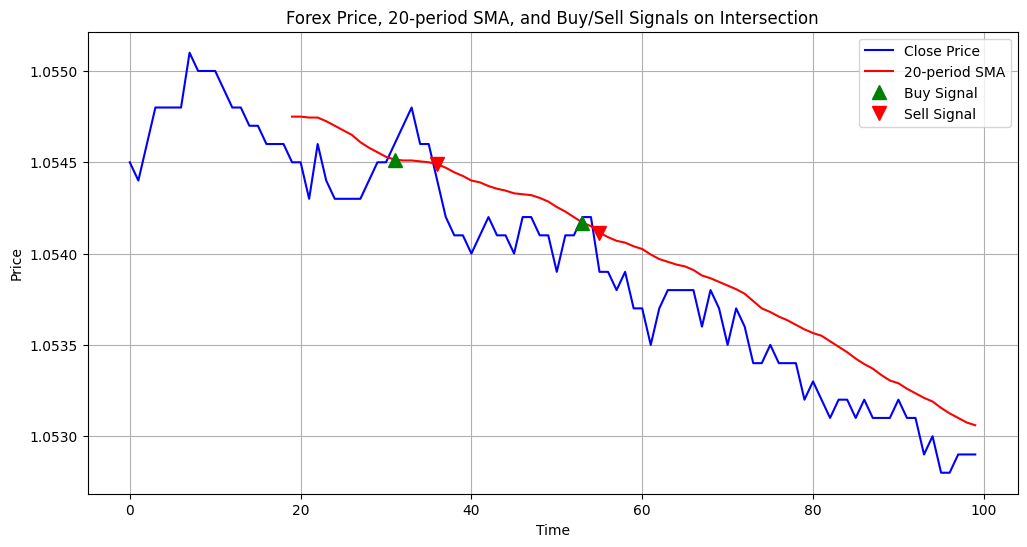

In [5]:

# Calculate 20-period SMA
data['SMA_20'] = data['close'].rolling(window=20).mean()

# Create a plot
plt.figure(figsize=(12, 6))

# Plot the closing price
plt.plot(data.index, data['close'], label='Close Price', color='blue')

# Plot the 20-period SMA
plt.plot(data.index, data['SMA_20'], label='20-period SMA', color='red')

# Initialize a 'Signal' column
data['Signal'] = 0  # 0 represents no action

# Generate buy (1) and sell (-1) signals based on the intersection
for i in range(1, len(data)):
    if data['close'][i] > data['SMA_20'][i] and data['close'][i - 1] <= data['SMA_20'][i - 1]:
        data['Signal'][i] = 1  # Buy signal
    elif data['close'][i] < data['SMA_20'][i] and data['close'][i - 1] >= data['SMA_20'][i - 1]:
        data['Signal'][i] = -1  # Sell signal

# Plot buy positions (green) and sell positions (red)
plt.plot(data[data['Signal'] == 1].index, data[data['Signal'] == 1]['SMA_20'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data[data['Signal'] == -1].index, data[data['Signal'] == -1]['SMA_20'], 'v', markersize=10, color='r', label='Sell Signal')

plt.title('Forex Price, 20-period SMA, and Buy/Sell Signals on Intersection')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()